## Imports

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import quotes_by_gender, unique_speaker_per_gender, get_champlex
from collections import Counter
import math
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
from wordcloud import WordCloud
import wordcloud
from PIL import Image

## Dataset


In [2]:
DATA_FOLDER = 'data/'
QUOTES_DATA = DATA_FOLDER + 'data_observational.json.bz2'

## Dictionnaries

In [3]:
DICTIONNARY_FOLDER = DATA_FOLDER + 'dictionnaries/'
DICT_OCCUPATIONS = DICTIONNARY_FOLDER + 'occupations_categories.json'
DICT_DEGREES = DICTIONNARY_FOLDER + 'degrees_categories.json'

## Attributes

In [4]:
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

In [5]:
attributes = pd.read_parquet(SPEAKER_ATTRIBUTES_DATA)

## Load the data

In [6]:
quotes = pd.read_json(QUOTES_DATA)

In [7]:
with open(DICT_OCCUPATIONS) as f:
    dict_occupations = json.load(f)

In [8]:
with open(DICT_DEGREES) as f:
    dict_degrees = json.load(f)

# Some preprocessing again

In [9]:
def translate(my_list, my_dict):
    """Allows to transform a list of items into a list of corresponding categories. 
    The list returned contains uniques category (the duplicates are removed).
    
    Parameters
    ----------
    my_list: the list to be translated
    my_dict: the dictionnary according which we want to translate the list
    
    Returns
    --------
    list of uniques categories"""
    translated_list = []
    for i in my_list:
        if i in my_dict.keys():
            translated_list.append(my_dict[i])
        else:
            translated_list.append('Others')
    #Drop duplicates
    return (list(set(translated_list)))
    
        

Now, we replace the occupations and academic degrees by more general categories

In [10]:
quotes['occupation'] = quotes['occupation'].apply(lambda x: translate(x, dict_occupations))

In [11]:
quotes['academic_degree'] = quotes['academic_degree'].apply(lambda x: translate(x, dict_degrees))

Prepare the dataset for propensity scores calculations:

In [12]:
print('Our dataset contains', quotes.shape[0], 'quotes from female speakers.')

Our dataset contains 1761820 quotes from female speakers.


Now, we want to calculate the propensity scores of each speaker. To do that, we need to group the quotations by speakers, and to recover some information about them.

In [13]:
grouped_speakers = quotes.groupby(['qids', 'label'])

After having grouped the quotations per speaker, we take the attributes corresponding to the first quotation: these attributes are immutable (the academic degree, the occupation, the speaker name and the gender), thus we can recover it from the first quotation.

In [14]:
attributes_immutable = grouped_speakers.first().reset_index().drop(['year', 
                                                                   'quotation', 'numOccurrences', 'age'], axis = 1)
attributes_immutable

,qids,label,speaker,gender,occupation,academic_degree
0,Q1000727,0,Ruslan Galitsky,male,[Military],[candidate]
1,Q100230,0,Ludger Kühnhardt,male,[Teaching],[doctor]
2,Q100308,1,Joachim Weimann,male,"[Teaching, Social Sciences, Writer]",[doctor]
3,Q1006191,1,F. Földényi,male,"[Journalism, Teaching, Fashion, Literature, Ar...",[Others]
4,Q100749,0,Clemens Fuest,male,"[Teaching, Social Sciences]",[doctor]
...,...,...,...,...,...,...
9343,Q996967,1,Diane Coyle,female,"[Journalism, Social Sciences, Teaching]",[doctor]
9344,Q99818,0,Holger Afflerbach,male,"[Historian, Teaching, Writer]",[doctor]
9345,Q99860,0,Ottmar Edenhofer,male,"[Teaching, Social Sciences]","[doctor, bachelor]"
9346,Q99860,1,Ottmar Edenhofer,male,"[Teaching, Social Sciences]","[doctor, bachelor]"


Now we will calculate the number of quotes per speaker, as well as the number of occurrences per speaker. We also put the age of the speaker to the median age of all its quotations. 

In [15]:
#Get the number of unique quotes per speaker
quotations_per_speaker = grouped_speakers['quotation'].count().reset_index(name='nb_quotes')

#Get the number of total occurrences of the speaker
occurrences_per_speaker = grouped_speakers['numOccurrences'].sum().reset_index(name='nb_occurrences')

#Get the median age of the speaker if she talks many times
age_per_speaker = grouped_speakers['age'].median().reset_index(name='age')

In [16]:
attributes_mutable = pd.merge(pd.merge(quotations_per_speaker, occurrences_per_speaker, on = ['qids', 'label']), 
                              age_per_speaker, on = ['qids', 'label'])
attributes_mutable.head()

,qids,label,nb_quotes,nb_occurrences,age
0,Q1000727,0,1,2,44.0
1,Q100230,0,1,1,59.0
2,Q100308,1,1,1,63.0
3,Q1006191,1,1,1,67.0
4,Q100749,0,300,1654,48.0


In [17]:
data_per_speaker = pd.merge(attributes_immutable, attributes_mutable, on = ['qids', 'label'])

Hot one encoding

In [18]:
dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)

/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_2538/3314558053.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_occ = pd.get_dummies(data_per_speaker['occupation'].explode()).sum(level=0)
/var/folders/n_/84v0r2b53yx61w33v8clz5500000gp/T/ipykernel_2538/3314558053.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_degree = pd.get_dummies(data_per_speaker['academic_degree'].explode()).sum(level=0)


In [57]:
dummies_gender = pd.get_dummies(data_per_speaker['gender'])

In [19]:
##C'est sombre mais get_dummies cree une colomn 'Others' donc en attendant de comprendre pq:
dummies_occ.drop(['Others'], axis = 1, inplace = True)
dummies_degree.drop(['Others'], axis = 1, inplace = True)

In [20]:
#Parce que la regression aime pas les espaces dans les noms de variables
dummies_occ.columns = dummies_occ.columns.str.replace(" ", "_")
dummies_degree.columns = dummies_degree.columns.str.replace(" ", "_")

In [59]:
data_features = pd.merge(pd.merge(data_per_speaker, dummies_occ, left_index = True, right_index = True), dummies_degree, left_index = True, right_index = True)
data_features = pd.merge(data_features, dummies_gender, left_index = True, right_index = True)

Before calculating the propensity scores, we should standardize the continuous features. Let's look at their distributions in order to choose an appropriate standardization. 

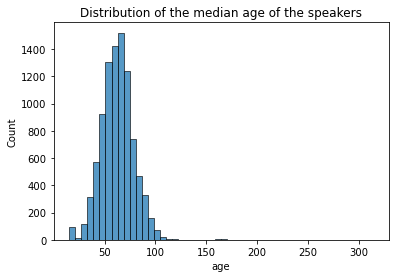

In [61]:
ax = sns.histplot(data_features['age'], bins = 50)
ax.set_title("Distribution of the median age of the speakers");

The distribution of the age seems to follow a gaussian distribution, thus, we will standardize it.

In [62]:
data_features['age'] = (data_features['age'] - data_features['age'].mean())/data_features['age'].std()
data_features.head(2)

,qids,label,speaker,gender,occupation,academic_degree,nb_quotes,nb_occurrences,age,Activist,...,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,female,male
0,Q1000727,0,Ruslan Galitsky,male,[Military],[candidate],1,2,-1.109912,0,...,1,0,0,0,0,0,0,0,0,1
1,Q100230,0,Ludger Kühnhardt,male,[Teaching],[doctor],1,1,-0.198774,0,...,0,0,1,0,0,0,0,0,0,1


Now the dataset is ready for the propensity scores calculation and matching (petit rappel de la théorie ici serait good!)

# Create a balanced dataset to reduce bias

Now the dataset is ready for the observational study: pair identical people, propensity scores calculation and matching (petit rappel de la théorie ici!)

First, we know that some speakers might appear before and after the #MeToo movement. We decide to pair them up, because the goal is to match 2 identical person in terms of their observal covariates, but here, we already know that they are the same person! With just a few years more. But we assume that the difference in age in minor compared to the fact that all other covariates are exaclty the same, and not only the observable ones, since it is the same person!
Thus, we first pair the identical speakers that appear in both groups (control and treated). Then, for the others (i.e, the speakers who speak ONLY before the movement or ONLY after), we will use the method of propensity scores calculation based on the observable covariates = `age`, `occupation`, `academic_degree`.

## Pair up identical speakers

In [63]:
print("Number of speakers speaking both before and after",
      data_features[data_features['qids'].duplicated(keep = 'first') == True].shape[0])

Number of speakers speaking both before and after 3363


In [64]:
data_features.drop(['academic_degree', 'occupation'], axis = 1, inplace = True)

In [65]:
speakers_twice = data_features[data_features['qids'].duplicated(keep = False) == True]

## Pair up non-identical speakers

In [66]:
speakers_once = pd.concat([data_features,speakers_twice])

In [67]:
speakers_once.drop_duplicates(keep = False, inplace = True)

In [68]:
print('Now, we will try to pair up the other speakers, they are:', speakers_once.shape[0])

Now, we will try to pair up the other speakers, they are: 2622


### Propensity scores calculation

In [69]:
occupations_for_regression = ['C('+ str(x)+ ')' for x in dummies_occ.columns.tolist()]

In [70]:
degrees_for_regression = ['C('+ str(x)+ ')' for x in dummies_degree.columns.tolist()]

In [71]:
def create_formula_from_list_categories(my_list):
    list_for_regression = ['C('+ str(x)+ ')' for x in my_list]
    formula = ''
    for i in list_for_regression:
        formula += i
        if i != list_for_regression[-1]:
            formula += ' + '
    return formula
    

In [72]:
formula_occupations = create_formula_from_list_categories(dummies_occ.columns.tolist())

In [73]:
formula_degrees = create_formula_from_list_categories(dummies_degree.columns.tolist())

In [77]:
mod = smf.logit(formula='label ~  age + ' + formula_occupations + ' + ' + formula_degrees + '+ C(female)', data=speakers_once)

res = mod.fit(maxiter = 100)

# Extract the estimated propensity scores
speakers_once['Propensity_score'] = res.predict()

print(res.summary())

         Current function value: 0.679217
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 2622
Model:                          Logit   Df Residuals:                     2570
Method:                           MLE   Df Model:                           51
Date:                Wed, 01 Dec 2021   Pseudo R-squ.:                 0.01898
Time:                        13:04:51   Log-Likelihood:                -1780.9
converged:                      False   LL-Null:                       -1815.4
Covariance Type:            nonrobust   LLR p-value:                   0.04792
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0608      0.177     -0.343      0.732      -0.408       0.286
C(Activist

/Users/lisa/opt/anaconda3/envs/ada/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Matching

In [37]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [38]:
speakers_once.head(2)

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,bachelor,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor,Propensity_score
0,Q1000727,0,Ruslan Galitsky,male,1,2,-1.109912,0,0,0,...,0,1,0,0,0,0,0,0,0,0.347381
1,Q100230,0,Ludger Kühnhardt,male,1,1,-0.198774,0,0,0,...,0,0,0,1,0,0,0,0,0,0.481673


Run the following cell to get the matching for both male and females:

In [ ]:
# Separate the treatment and control groups
treatment_df = speakers_once[speakers_once['label'] == 1]
control_df = speakers_once[speakers_once['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [ ]:
balanced_speakers_once = speakers_once.loc[matched]

In [ ]:
balanced_speakers = pd.concat(balanced_speakers_once, speakers_twice)

In [ ]:
##Pour éviter de run again le matching 
balanced_df_by_gender.to_json(DATA_FOLDER + 'results/balanced_dataset_by_gender.json.bz2')

In [ ]:
#On sauvegarde aussi les valeurs de paires
textfile = open("matching_by_gender.txt", "w")
for element in matching:
    textfile.write(str(element) + "\n")
textfile.close()

# Results

### Essai sur les femmes en attendant d'avoir le dataset total

In [39]:
speakers_once_female = speakers_once[speakers_once['gender'] == 'female']

In [40]:
# Separate the treatment and control groups
treatment_df = speakers_once_female[speakers_once_female['label'] == 1]
control_df = speakers_once_female[speakers_once_female['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [41]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [42]:
balanced_speakers_once_female = speakers_once_female.loc[matched]

In [43]:
balanced_speakers_twice_female = speakers_twice[speakers_twice['gender'] == 'female']

In [44]:
balanced_speakers_female = pd.concat([balanced_speakers_once_female,balanced_speakers_twice_female])

In [45]:
print('Mean quotes per women before #MeToo', 
      balanced_speakers_female[balanced_speakers_female['label'] == 0]['nb_quotes'].mean())
print('Mean quotes per women after #MeToo', 
      balanced_speakers_female[balanced_speakers_female['label'] == 1]['nb_quotes'].mean())
print('Median quotes per women before #MeToo',
      balanced_speakers_female[balanced_speakers_female['label'] == 0]['nb_quotes'].median())
print('Median quotes per women after #MeToo',
      balanced_speakers_female[balanced_speakers_female['label'] == 1]['nb_quotes'].median())

Mean quotes per women before #MeToo 134.00305188199388
Mean quotes per women after #MeToo 177.3855544252289
Median quotes per women before #MeToo 7.0
Median quotes per women after #MeToo 11.0


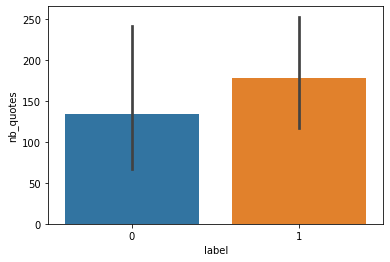

In [46]:
ax = sns.barplot(x="label", y="nb_quotes", data=balanced_speakers_female.loc[balanced_speakers_female['label'].isin([0,1])])


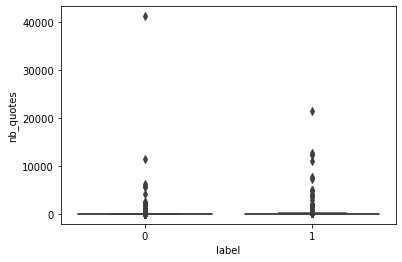

In [47]:
ax = sns.boxplot(x="label", y="nb_quotes", data=balanced_speakers_female.loc[balanced_speakers_female['label'].isin([0,1])])

In [48]:
plot_see = balanced_speakers_female[balanced_speakers_female['nb_quotes'] < 100]

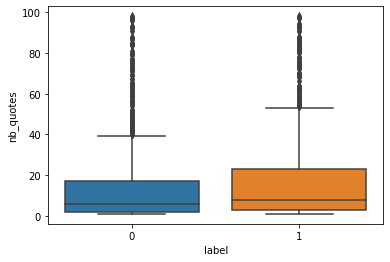

In [49]:
ax = sns.boxplot(x="label", y="nb_quotes", data=plot_see.loc[plot_see['label'].isin([0,1])])

## By categories

### Scientists (juste les femmes pour l'instant, run pour les hommes)

In [50]:
# Separate the treatment and control groups
treatment_df = speakers_once_female[speakers_once_female['label'] == 1]
control_df = speakers_once_female[speakers_once_female['label'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        # Adds an edge only if the individuals have the same gender
        if (control_row['gender'] == treatment_row['gender']) and (control_row['Scientist'] == treatment_row['Scientist']):
            similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [51]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [52]:
balanced_speakers_once = speakers_once_female.loc[matched]

In [53]:
balanced_scientist = pd.concat([balanced_speakers_once, speakers_twice[speakers_twice['gender'] == 'female']])

In [54]:
non_scientists = balanced_scientist[balanced_scientist['Scientist'] == 0]
scientists = balanced_scientist[balanced_scientist['Scientist'] == 1]

## Results

In [55]:
print('Median quotes of female scientists before:', scientists[scientists['label'] == 0]['nb_quotes'].median())
print('Median quotes of female scientists after:', scientists[scientists['label'] == 1]['nb_quotes'].median())

Median quotes of female scientists before: 9.0
Median quotes of female scientists after: 11.0


In [56]:
print('Median quotes of female non scientists before:', non_scientists[non_scientists['label'] == 0]['nb_quotes'].median())
print('Median quotes of female non scientists after:', non_scientists[non_scientists['label'] == 1]['nb_quotes'].median())

Median quotes of female non scientists before: 7.0
Median quotes of female non scientists after: 12.0


# A checker au moment d'analyser les outcomes: je crois que nb_occurences et nb_quotes sont des heavy tailed distributions! Voir comment on peut les analyser.

In [163]:
data_features['nb_occurrences'].describe()

count    9.348000e+03
mean     1.292966e+03
std      3.148327e+04
min      1.000000e+00
25%      4.000000e+00
50%      1.300000e+01
75%      7.300000e+01
max      2.802297e+06
Name: nb_occurrences, dtype: float64

In [164]:
data_features[data_features['qids'] == 'Q6294']

,qids,label,speaker,gender,nb_quotes,nb_occurrences,age,Activist,Administrative,Artist,...,aggregation,bachelor,candidate,certificate,doctor,high_school_diploma,master,non_specified_degree,not_classified,professor
7939,Q6294,0,Hillary Clinton,female,41261,274275,0.408650,0,0,0,...,0,1,0,0,1,0,0,0,0,0
7940,Q6294,1,Hillary Clinton,female,11137,60926,0.530135,0,0,0,...,0,1,0,0,1,0,0,0,0,0


Hillary Clinton a 274275 citations avant #MeToo. Seulement 60926 après (du aux éléctions).

### GRAPHHH ####

In [2]:
DATA_FOLDER_RESULT = 'data/results/'
BALANCED_DATA_BY_GENDER = DATA_FOLDER_RESULT + 'balanced_dataset_by_gender.json.bz2'
BALANCED_DATA_FEMALE = DATA_FOLDER_RESULT + 'balanced_dataset_female.json.bz2'


In [3]:
balanced_all_genders = pd.read_json(BALANCED_DATA_BY_GENDER)
balanced_female = pd.read_json(BALANCED_DATA_FEMALE)

In [4]:
print('Mean quotes per women before #MeToo', 
      balanced_female[balanced_female['label'] == 0]['nb_quotes'].mean())
print('Mean quotes per women after #MeToo', 
      balanced_female[balanced_female['label'] == 1]['nb_quotes'].mean())
print('Median quotes per women before #MeToo',
      balanced_female[balanced_female['label'] == 0]['nb_quotes'].median())
print('Median quotes per women after #MeToo',
      balanced_female[balanced_female['label'] == 1]['nb_quotes'].median())

Mean quotes per women before #MeToo 134.00305188199388
Mean quotes per women after #MeToo 173.8769074262462
Median quotes per women before #MeToo 7.0
Median quotes per women after #MeToo 11.0


### CREATION OF A WORLDCLOUD

In [5]:
#converts my list into a dict, useful for generation of worldcloud : 
def Convert(lst):
    res_dct = {lst[i][0]: lst[i][0+1] for i in range(0, len(lst))}
    return res_dct

In [6]:
def create_Worldcloud(df,mask_image):
    tupl = [tuple(x) for x in df.values]
    dict_ready = Convert(tupl)
    mask_ = np.array(Image.open(mask_image))
    df_wordcloud = wordcloud.WordCloud(background_color="white", max_words=500, mask=mask_,contour_width=3, contour_color='peru').generate_from_frequencies(dict_ready)
    return df_wordcloud

In [7]:
df_occ_female = balanced_female.occupation.explode(ignore_index=True)
most_occ_female=pd.DataFrame(Counter(df_occ_female).most_common(),columns =['occupation', 'nb_occurences'])
print(most_occ_female.head())

        occupation  nb_occurences
0         Teaching            603
1       Government            520
2        Scientist            475
3           Writer            330
4  Social Sciences            282


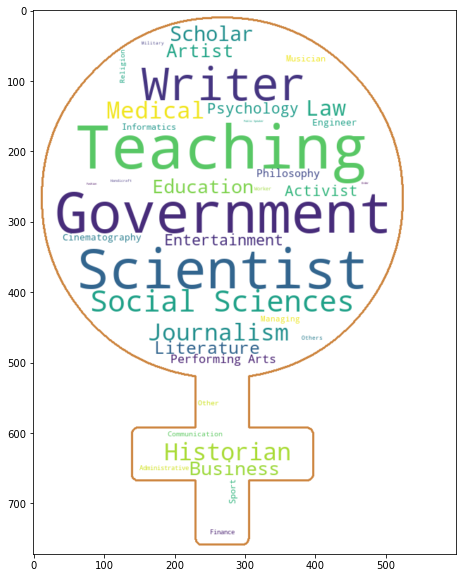

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.imshow(create_Worldcloud(most_occ_female,'data/female.png'),cmap=plt.cm.gray,interpolation="bilinear")

### BEFORE AFTER ME TOO

In [9]:
df_occ_female_before = balanced_female[balanced_female['label']==0].occupation.explode(ignore_index=True)
df_occ_female_after = balanced_female[balanced_female['label']==1].occupation.explode(ignore_index=True)

In [13]:
#Compute the reprensented occupations for female speakers before me too
most_occ_female_before=pd.DataFrame(Counter(df_occ_female_before).most_common(),columns =['occupation', 'nb_occurences'])
print(most_occ_female_before.head())

#Compute the reprensented occupations for female speakers after me too
most_occ_female_after=pd.DataFrame(Counter(df_occ_female_after).most_common(),columns =['occupation', 'nb_occurences'])
print(most_occ_female_after.head())

        occupation  nb_occurences
0         Teaching            308
1       Government            257
2        Scientist            234
3           Writer            170
4  Social Sciences            143
        occupation  nb_occurences
0         Teaching            295
1       Government            263
2        Scientist            241
3           Writer            160
4  Social Sciences            139


In [11]:

Worldcloud_before = create_Worldcloud(most_occ_female_before,'data/female.png')
Worldcloud_after = create_Worldcloud(most_occ_female_after,'data/female.png')

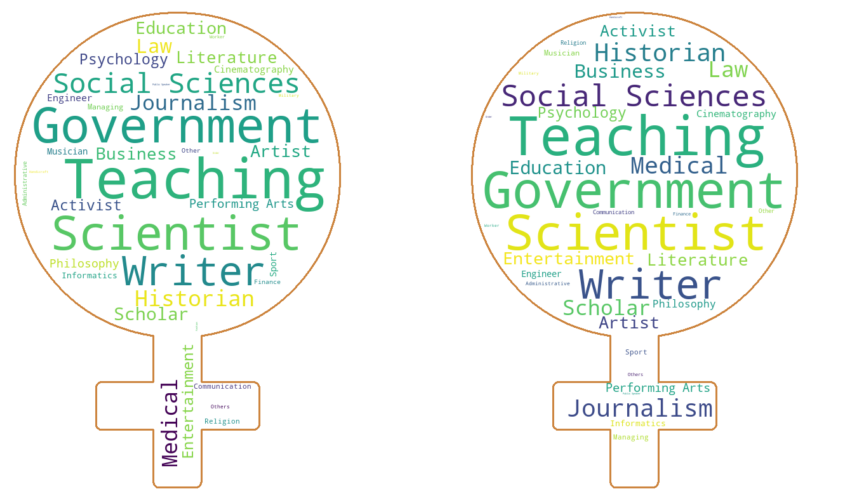

In [12]:
fig,ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(Worldcloud_before, cmap=plt.cm.gray, interpolation="bilinear")
ax[0].axis("off")
ax[1].imshow(Worldcloud_after, cmap=plt.cm.gray, interpolation="bilinear")
ax[1].axis("off")
plt.show()